In [1]:
!pip install bertviz
!pip install sklearn-crfsuite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 8.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manyl

## Get data & load libraries

*   Uploading specific files from Google Drive to my Google Colab Notebook
*   Libraries loaded by trainer.py





In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# cd "/content/drive/MyDrive/CS5228/emotions/"

In [2]:
# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

processed_text_id = '13h01vbr-gAiBWrvjtzGFg6MQSM5USNuQ' #<-- You add in here the id from you google drive file, you can find it
processed_text_balanced_id = '1l2wnu5MURIfvE3-Bd4CCt6kzP8UzLJsU' #<-- You add in here the id from you google drive file, you can find it
processed_dialogues_id = '12tamLcWNuw0ixgh554XYosySoNy1JTeK' #<-- You add in here the id from you google drive file, you can find it
trainer_id = '1NLAUXAJc_AUGKfC_n8dmdKwEVNHkH_rZ' #<-- You add in here the id from you google drive file, you can find it

download = drive.CreateFile({'id': processed_text_id})
download.GetContentFile('processed_text.json')

download = drive.CreateFile({'id': processed_text_balanced_id})
download.GetContentFile('processed_text_balanced.json')

download = drive.CreateFile({'id': processed_dialogues_id})
download.GetContentFile('processed_dialogues.json')

download = drive.CreateFile({'id': trainer_id})
download.GetContentFile('trainer.py')

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# import libraries for model training
# as well as retrieve data
# as well as functions for doing hyperparameter tuning
from trainer import *

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## RoBERTa classification:
Take note, might need more gpu and/or restart session to free up space.

1.   Multi-class Classification
2.   Multi-class Classification (w previous utterances as context)



### Multi-Class Classification
Never do hyperparameter tuning. Not much difference, except some extreme hyperparamter values to avoid.

In [ ]:
# data split
train = data[data.split == "train"]
dev = data[data.split == "dev"]
test = data[data.split == "test"]
num_labels = len(np.unique(train.sentiment))

In [ ]:
# tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path, do_lower_case=True)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels).to("cuda")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class myDataset(Dataset):

    def __init__(self, X, y, tokenizer, max_len, label_mapper):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_mapper = label_mapper

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = str(self.X[idx])
        encoding = self.tokenizer.encode_plus(
            x,
            add_special_tokens = True,
            max_length = self.max_len,
            padding = 'max_length',
            truncation = 'longest_first',
            return_attention_mask = True,
            return_token_type_ids = False,
            return_tensors = 'pt'
        )
        return{
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.label_mapper[self.y[idx]], dtype = torch.long)
        }

def create_data_loader(some_df, tokenizer, max_len, batch_size, label_mapper, purpose):
    ds = myDataset(
        X = some_df.raw.to_numpy(),
        y = some_df.sentiment.to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len,
        label_mapper = label_mapper
    )
    if purpose == 'train':
        return DataLoader(
            ds,
            batch_size = batch_size,
            sampler = RandomSampler(ds),
            num_workers = 2
        )
    if purpose == 'val':
        return DataLoader(
            ds,
            batch_size = batch_size,
            sampler = SequentialSampler(ds),
            num_workers = 2
        )

In [ ]:
# dataset and dataloader
label_mapper = {y: i for i, y in enumerate(np.unique(train.sentiment))}
MAX_LEN = 80
BATCH_SIZE = 64 #

train_dataloader = create_data_loader(train, tokenizer, MAX_LEN, BATCH_SIZE, label_mapper, 'train')
validation_dataloader = create_data_loader(dev, tokenizer, MAX_LEN, BATCH_SIZE, label_mapper, 'val')
test_dataloader = create_data_loader(test, tokenizer, MAX_LEN, BATCH_SIZE, label_mapper, 'val')

label_mapper

{'negative': 0, 'neutral': 1, 'positive': 2}

In [ ]:
# loss and optimizer
EPOCHS = 5

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 2e-4
                  eps = 1e-8)

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = total_steps * 0.05, # total_steps * 0.05
                                            num_training_steps = total_steps)
#"balanced"
class_weights = compute_class_weight(class_weight=None, classes=np.array(range(len(label_mapper))), y=(train['sentiment'].map(label_mapper)).tolist())
criterion = nn.CrossEntropyLoss(weight = torch.tensor(class_weights, dtype = torch.float)).to("cuda")

print(class_weights)

[1. 1. 1.]


In [ ]:
# training
RANDOM_SEED = 2024
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []
best_f1 = 0
best_epoch = None

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(EPOCHS):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update
        if step % 20 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch['input_ids'].to("cuda")
        b_input_mask = batch['attention_mask'].to("cuda")
        b_labels = batch['labels'].to("cuda")

        # Perform a forward pass (evaluate the model on this training batch).
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        y_pred = model(input_ids=b_input_ids, attention_mask=b_input_mask)

        # Get the loss and "logits" output by the model.
        logits = y_pred.logits
        loss = criterion(logits, b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end.
        total_train_loss += loss.item()

        # Always clear any previously calculated gradients before performing a
        # backward pass.
        optimizer.zero_grad()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_loss = 0
    predictions, true_labels = [], []

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch['input_ids'].to("cuda")
        b_input_mask = batch['attention_mask'].to("cuda")
        b_labels = batch['labels'].to("cuda")

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            y_val = model(input_ids=b_input_ids, attention_mask=b_input_mask)

        # Get the loss and "logits" output by the model.
        logits = y_val.logits
        loss = criterion(logits, b_labels)

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu()
        label_ids = b_labels.to('cpu')

        # Store predictions and true labels (only used to evaluate last epoch)
        predictions.extend(logits)
        true_labels.extend(label_ids)


    # Report the final accuracy for this validation run.
    predictions = torch.argmax(torch.stack(predictions), 1)
    true_labels = torch.stack(true_labels)
    f1 = f1_score(true_labels, predictions, average = "macro")
    print("  Valition F1 score: {0:.2f}".format(f1))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. F1 score.': f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

    if f1 > best_f1:
        torch.save(model.state_dict(), 'model.pt') ###
        best_f1 = f1
        best_epoch = epoch_i + 1

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

print("Best F1 is", best_f1, "at", best_epoch)


======== Epoch 1 / 5 ========
Training...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  Batch    20  of    129.    Elapsed: 0:00:16.
  Batch    40  of    129.    Elapsed: 0:00:31.
  Batch    60  of    129.    Elapsed: 0:00:46.
  Batch    80  of    129.    Elapsed: 0:01:02.
  Batch   100  of    129.    Elapsed: 0:01:17.
  Batch   120  of    129.    Elapsed: 0:01:31.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



  Average training loss: 0.88
  Training epcoh took: 0:01:38

Running Validation...
  Valition F1 score: 0.59
  Validation Loss: 0.94
  Validation took: 0:00:05

======== Epoch 2 / 5 ========
Training...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  Batch    20  of    129.    Elapsed: 0:00:15.
  Batch    40  of    129.    Elapsed: 0:00:30.
  Batch    60  of    129.    Elapsed: 0:00:45.
  Batch    80  of    129.    Elapsed: 0:01:00.
  Batch   100  of    129.    Elapsed: 0:01:15.
  Batch   120  of    129.    Elapsed: 0:01:30.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



  Average training loss: 0.68
  Training epcoh took: 0:01:37

Running Validation...
  Valition F1 score: 0.64
  Validation Loss: 0.86
  Validation took: 0:00:04

======== Epoch 3 / 5 ========
Training...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  Batch    20  of    129.    Elapsed: 0:00:15.
  Batch    40  of    129.    Elapsed: 0:00:30.
  Batch    60  of    129.    Elapsed: 0:00:45.
  Batch    80  of    129.    Elapsed: 0:01:00.
  Batch   100  of    129.    Elapsed: 0:01:15.
  Batch   120  of    129.    Elapsed: 0:01:30.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



  Average training loss: 0.57
  Training epcoh took: 0:01:37

Running Validation...
  Valition F1 score: 0.64
  Validation Loss: 0.84
  Validation took: 0:00:04

======== Epoch 4 / 5 ========
Training...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  Batch    20  of    129.    Elapsed: 0:00:15.
  Batch    40  of    129.    Elapsed: 0:00:30.
  Batch    60  of    129.    Elapsed: 0:00:45.
  Batch    80  of    129.    Elapsed: 0:01:00.
  Batch   100  of    129.    Elapsed: 0:01:15.
  Batch   120  of    129.    Elapsed: 0:01:30.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



  Average training loss: 0.50
  Training epcoh took: 0:01:37

Running Validation...
  Valition F1 score: 0.63
  Validation Loss: 0.92
  Validation took: 0:00:05

======== Epoch 5 / 5 ========
Training...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  Batch    20  of    129.    Elapsed: 0:00:15.
  Batch    40  of    129.    Elapsed: 0:00:30.
  Batch    60  of    129.    Elapsed: 0:00:45.
  Batch    80  of    129.    Elapsed: 0:01:00.
  Batch   100  of    129.    Elapsed: 0:01:15.
  Batch   120  of    129.    Elapsed: 0:01:30.

  Average training loss: 0.45
  Training epcoh took: 0:01:37

Running Validation...
  Valition F1 score: 0.63
  Validation Loss: 0.97
  Validation took: 0:00:05

Training complete!
Total training took 0:08:33 (h:mm:ss)
Best F1 is 0.6434640708175398 at 3


<Axes: xlabel='epochs'>

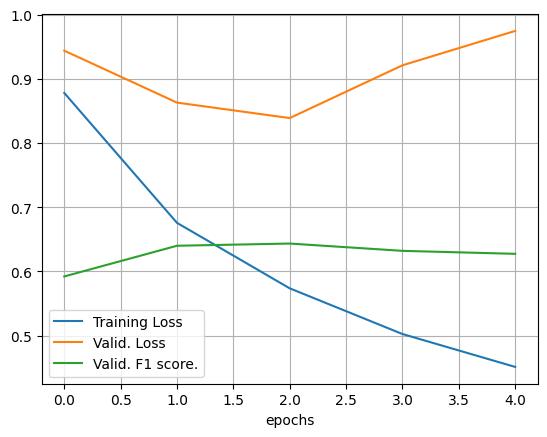

In [ ]:
stats_df = pd.DataFrame(training_stats)[["Training Loss", "Valid. Loss", "Valid. F1 score."]]
stats_df.plot(xlabel = "epochs", grid = True)

In [ ]:
# evaluation
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels)
model.load_state_dict(torch.load('model.pt')) ###
model.to("cuda")
model.eval()

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test.shape[0]))

# Tracking variables
predictions, true_labels = [], []

# Predict
for batch in test_dataloader:
    # Add batch to GPU
    # Unpack the inputs from our dataloader
    b_input_ids = batch['input_ids'].to("cuda")
    b_input_mask = batch['attention_mask'].to("cuda")
    b_labels = batch['labels'].to("cuda")

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        y_val = model(input_ids=b_input_ids, attention_mask=b_input_mask)

    logits = y_val.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu()
    label_ids = b_labels.to('cpu')

    # Store predictions and true labels
    predictions.extend(logits)
    true_labels.extend(label_ids)

predictions = torch.argmax(torch.stack(predictions), 1)
true_labels = torch.stack(true_labels)

print('DONE.')

### Can edit your evaluation metric here
print(f1_score(true_labels, predictions, average = "macro"))
print(classification_report(true_labels, predictions, target_names = list(label_mapper.keys())))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of test sentences: 2,610



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


DONE.
0.6715846989933124
              precision    recall  f1-score   support

    negative       0.61      0.70      0.65       833
     neutral       0.81      0.70      0.75      1256
    positive       0.59      0.64      0.62       521

    accuracy                           0.69      2610
   macro avg       0.67      0.68      0.67      2610
weighted avg       0.70      0.69      0.69      2610



### Multi-class Classification (w previous utterances as context)
We feed in previous 3 utterances as context for pedicting emotion of current utterance.

In [ ]:
# data splits
data_no_bal = pd.DataFrame(data_no_bal)
train = data_no_bal[data_no_bal.split == "train"]
dev = data_no_bal[data_no_bal.split == "dev"]
test = data_no_bal[data_no_bal.split == "test"]
num_labels = len(np.unique(train.sentiment))

In [ ]:
# get previous 3 utterances
def get_contexts(df):
  dialogues = {}
  for d, r, y in zip(df.diaID, df.raw, df.sentiment):
    if d not in dialogues:
      dialogues[d] = {"utterances": [r], "y": [y]}
    else:
      dialogues[d]["utterances"].append(r)
      dialogues[d]["y"].append(y)

  for d in dialogues:
    contexts = []
    for i in range(len(dialogues[d]["utterances"])):
      if i == 0:
        contexts.append("")
      elif i == 1:
        contexts.append(" ".join(dialogues[d]["utterances"][:1]))
      elif i == 2:
        contexts.append(" ".join(dialogues[d]["utterances"][:2]))
      else:
        contexts.append(" ".join(dialogues[d]["utterances"][i-3:i]))
    dialogues[d]["contexts"] = contexts

  utterances = []
  y = []
  contexts = []
  for d in dialogues:
    for i in range(len(dialogues[d]["utterances"])):
      utterances.append(dialogues[d]["utterances"][i])
      y.append(dialogues[d]["y"][i])
      contexts.append(dialogues[d]["contexts"][i])
  df = pd.DataFrame()
  df["raw"] = utterances
  df["sentiment"] = y
  df["contexts"] = contexts
  return df

In [ ]:
train = get_contexts(train)
dev = get_contexts(dev)
test = get_contexts(test)

In [ ]:
class myDataset(Dataset):

    def __init__(self, X, C, y, tokenizer, max_len, label_mapper):
        self.X = X
        self.C = C
        self.y = y
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_mapper = label_mapper

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = str(self.X[idx])
        c = str(self.C[idx])
        encoding = self.tokenizer.encode_plus(
            c, x, ###
            add_special_tokens = True,
            max_length = self.max_len,
            padding = 'max_length',
            truncation = 'longest_first',
            return_attention_mask = True,
            return_token_type_ids = False,
            return_tensors = 'pt'
        )
        return{
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.label_mapper[self.y[idx]], dtype = torch.long)
        }

def create_data_loader(some_df, tokenizer, max_len, batch_size, label_mapper, purpose):
    ds = myDataset(
        X = some_df.raw.to_numpy(),
        C = some_df.contexts.to_numpy(),
        y = some_df.sentiment.to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len,
        label_mapper = label_mapper
    )
    if purpose == 'train':
        return DataLoader(
            ds,
            batch_size = batch_size,
            sampler = RandomSampler(ds),
            num_workers = 2
        )
    if purpose == 'val':
        return DataLoader(
            ds,
            batch_size = batch_size,
            sampler = SequentialSampler(ds),
            num_workers = 2
        )

In [ ]:
# dataset and dataloader
label_mapper = {y: i for i, y in enumerate(np.unique(train.sentiment))}
MAX_LEN = 140 ###
BATCH_SIZE = 64 ###

train_dataloader = create_data_loader(train, tokenizer, MAX_LEN, BATCH_SIZE, label_mapper, 'train')
validation_dataloader = create_data_loader(dev, tokenizer, MAX_LEN, BATCH_SIZE, label_mapper, 'val')
test_dataloader = create_data_loader(test, tokenizer, MAX_LEN, BATCH_SIZE, label_mapper, 'val')

label_mapper

{'negative': 0, 'neutral': 1, 'positive': 2}

In [ ]:
# model
tokenizer = AutoTokenizer.from_pretrained(model_path, do_lower_case=True)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels).to("cuda")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# loss and optimizer
EPOCHS = 5

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 2e-4
                  eps = 1e-8)

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = total_steps * 0.05, # total_steps * 0.05
                                            num_training_steps = total_steps)
class_weights = compute_class_weight(class_weight="balanced", classes=np.array(range(len(label_mapper))), y=(train['sentiment'].map(label_mapper)).tolist())
criterion = nn.CrossEntropyLoss(weight = torch.tensor(class_weights, dtype = torch.float)).to("cuda")

print(class_weights)

[1.13061686 0.7069356  1.4265924 ]


In [ ]:
# training
RANDOM_SEED = 2024
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []
best_f1 = 0
best_epoch = None

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(EPOCHS):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update
        if step % 30 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch['input_ids'].to("cuda")
        b_input_mask = batch['attention_mask'].to("cuda")
        b_labels = batch['labels'].to("cuda")

        # Perform a forward pass (evaluate the model on this training batch).
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        y_pred = model(input_ids=b_input_ids, attention_mask=b_input_mask)

        # Get the loss and "logits" output by the model.
        logits = y_pred.logits
        loss = criterion(logits, b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end.
        total_train_loss += loss.item()

        # Always clear any previously calculated gradients before performing a
        # backward pass.
        optimizer.zero_grad()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_loss = 0
    predictions, true_labels = [], []

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch['input_ids'].to("cuda")
        b_input_mask = batch['attention_mask'].to("cuda")
        b_labels = batch['labels'].to("cuda")

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            y_val = model(input_ids=b_input_ids, attention_mask=b_input_mask)

        # Get the loss and "logits" output by the model.
        logits = y_val.logits
        loss = criterion(logits, b_labels)

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu()
        label_ids = b_labels.to('cpu')

        # Store predictions and true labels (only used to evaluate last epoch)
        predictions.extend(logits)
        true_labels.extend(label_ids)


    # Report the final accuracy for this validation run.
    predictions = torch.argmax(torch.stack(predictions), 1)
    true_labels = torch.stack(true_labels)
    f1 = f1_score(true_labels, predictions, average = "macro")
    print("  Valition F1 score: {0:.2f}".format(f1))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. F1 score.': f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

    if f1 > best_f1:
        torch.save(model.state_dict(), 'model.pt') ###
        best_f1 = f1
        best_epoch = epoch_i + 1

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

print("Best F1 is", best_f1, "at", best_epoch)


======== Epoch 1 / 5 ========
Training...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  Batch    30  of    157.    Elapsed: 0:00:39.
  Batch    60  of    157.    Elapsed: 0:01:19.
  Batch    90  of    157.    Elapsed: 0:02:00.
  Batch   120  of    157.    Elapsed: 0:02:41.
  Batch   150  of    157.    Elapsed: 0:03:21.

  Average training loss: 0.95
  Training epcoh took: 0:03:31

Running Validation...
  Valition F1 score: 0.64
  Validation Loss: 0.85
  Validation took: 0:00:08

======== Epoch 2 / 5 ========
Training...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  Batch    30  of    157.    Elapsed: 0:00:40.
  Batch    60  of    157.    Elapsed: 0:01:21.
  Batch    90  of    157.    Elapsed: 0:02:01.
  Batch   120  of    157.    Elapsed: 0:02:42.
  Batch   150  of    157.    Elapsed: 0:03:23.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



  Average training loss: 0.74
  Training epcoh took: 0:03:32

Running Validation...
  Valition F1 score: 0.66
  Validation Loss: 0.76
  Validation took: 0:00:08

======== Epoch 3 / 5 ========
Training...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  Batch    30  of    157.    Elapsed: 0:00:40.
  Batch    60  of    157.    Elapsed: 0:01:21.
  Batch    90  of    157.    Elapsed: 0:02:01.
  Batch   120  of    157.    Elapsed: 0:02:42.
  Batch   150  of    157.    Elapsed: 0:03:22.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



  Average training loss: 0.63
  Training epcoh took: 0:03:31

Running Validation...
  Valition F1 score: 0.67
  Validation Loss: 0.81
  Validation took: 0:00:08

======== Epoch 4 / 5 ========
Training...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  Batch    30  of    157.    Elapsed: 0:00:40.
  Batch    60  of    157.    Elapsed: 0:01:21.
  Batch    90  of    157.    Elapsed: 0:02:01.
  Batch   120  of    157.    Elapsed: 0:02:42.
  Batch   150  of    157.    Elapsed: 0:03:22.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



  Average training loss: 0.55
  Training epcoh took: 0:03:31

Running Validation...
  Valition F1 score: 0.67
  Validation Loss: 0.80
  Validation took: 0:00:08

======== Epoch 5 / 5 ========
Training...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  Batch    30  of    157.    Elapsed: 0:00:40.
  Batch    60  of    157.    Elapsed: 0:01:21.
  Batch    90  of    157.    Elapsed: 0:02:01.
  Batch   120  of    157.    Elapsed: 0:02:42.
  Batch   150  of    157.    Elapsed: 0:03:23.

  Average training loss: 0.49
  Training epcoh took: 0:03:32

Running Validation...
  Valition F1 score: 0.67
  Validation Loss: 0.85
  Validation took: 0:00:08

Training complete!
Total training took 0:18:28 (h:mm:ss)
Best F1 is 0.67478702743523 at 4


<Axes: xlabel='epochs'>

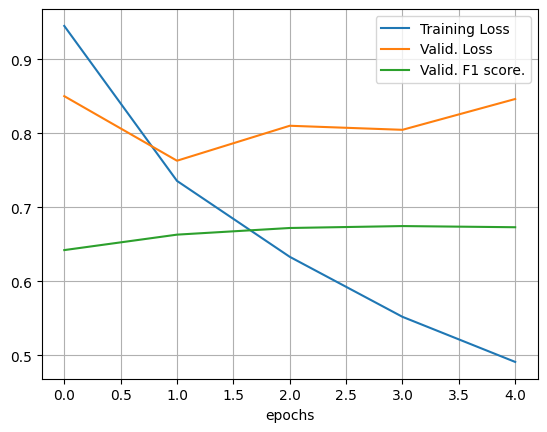

In [ ]:
stats_df = pd.DataFrame(training_stats)[["Training Loss", "Valid. Loss", "Valid. F1 score."]]
stats_df.plot(xlabel = "epochs", grid = True)

In [ ]:
# evaluation
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels)
model.load_state_dict(torch.load('model.pt')) ###
model.to("cuda")
model.eval()

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test.shape[0]))

# Tracking variables
predictions, true_labels = [], []

# Predict
for batch in test_dataloader:
    # Add batch to GPU
    # Unpack the inputs from our dataloader
    b_input_ids = batch['input_ids'].to("cuda")
    b_input_mask = batch['attention_mask'].to("cuda")
    b_labels = batch['labels'].to("cuda")

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        y_val = model(input_ids=b_input_ids, attention_mask=b_input_mask)

    logits = y_val.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu()
    label_ids = b_labels.to('cpu')

    # Store predictions and true labels
    predictions.extend(logits)
    true_labels.extend(label_ids)

predictions = torch.argmax(torch.stack(predictions), 1)
true_labels = torch.stack(true_labels)

print('DONE.')

### Can edit your evaluation metric here
print(f1_score(true_labels, predictions, average = "macro"))
print(classification_report(true_labels, predictions, target_names = list(label_mapper.keys())))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of test sentences: 2,610



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


DONE.
0.6862660310031382
              precision    recall  f1-score   support

    negative       0.67      0.64      0.66       833
     neutral       0.80      0.75      0.77      1256
    positive       0.58      0.69      0.63       521

    accuracy                           0.70      2610
   macro avg       0.68      0.70      0.69      2610
weighted avg       0.71      0.70      0.71      2610



## Modelling emotions in dialogues using RNN model
* feed RoBERTa [CLS] token of each utterance into a RNN/LSTM unit
* do sequence labelling (many to many), predict emotion for each utterance
* to calculate loss at each time step
* and then aggregate finally back propagate loss

In [6]:
df = pd.DataFrame(data_diag)
train_df = df[df["split"] == "train"]
dev_df = df[df["split"] == "dev"]
test_df = df[df["split"] == "test"]

In [7]:
### create pytorch dataset and tokenize
class EqualLengthsBatchSampler(Sampler):

    def __init__(self, batch_size, inputs, targets):

        # Throw an error if the number of inputs and targets don't match
        if targets is not None:
            if len(inputs) != len(targets):
                raise Exception("[EqualLengthsBatchSampler] inputs and targets have different sizes")

        # Remember batch size and number of samples
        self.batch_size, self.num_samples = batch_size, len(inputs)

        self.unique_length_pairs = set()
        self.lengths_to_samples = {}

        for i in range(0, len(inputs)):
            len_input = len(inputs[i])
            try:
                # Fails if targets[i] is not a sequence but a scalar (e.g., a class label)
                len_target = len(targets[i])
            except:
                # In case of failure, we just the length to 1 (value doesn't matter, it only needs to be a constant)
                len_target = 1

            # Add length pair to set of all seen pairs
            self.unique_length_pairs.add((len_input, len_target))

            # For each lengths pair, keep track of which sample indices for this pair
            # E.g.: self.lengths_to_sample = { (4,5): [3,5,11], (5,5): [1,2,9], ...}
            if (len_input, len_target) in self.lengths_to_samples:
                self.lengths_to_samples[(len_input, len_target)].append(i)
            else:
                self.lengths_to_samples[(len_input, len_target)] = [i]

        # Convert set of unique length pairs to a list so we can shuffle it later
        self.unique_length_pairs = list(self.unique_length_pairs)


    def __len__(self):
        return self.num_samples

    def __iter__(self):

        # Shuffle list of unique length pairs
        np.random.shuffle(self.unique_length_pairs)

        # Iterate over all possible sentence length pairs
        for length_pair in self.unique_length_pairs:

            # Get indices of all samples for the current length pairs
            # for example, all indices with a lenght pair of (8,7)
            sequence_indices = self.lengths_to_samples[length_pair]
            sequence_indices = np.array(sequence_indices)

            # Shuffle array of sequence indices
            np.random.shuffle(sequence_indices)

            # Compute the number of batches
            num_batches = np.ceil(len(sequence_indices) / self.batch_size)

            # Loop over all possible batches
            for batch_indices in np.array_split(sequence_indices, num_batches):
                yield np.asarray(batch_indices)

class myDataset(Dataset):

    def __init__(self, X, y, tokenizer, max_len, label_mapping):
        self.X = X # list of dialogues
        self.y = y # list of emotion sequences
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # a dialogue (list of utterances)
        x = list(self.X[idx])
        encoding = self.tokenizer.batch_encode_plus(
            x,
            add_special_tokens = True,
            max_length = self.max_len,
            padding = 'max_length',
            truncation = 'longest_first',
            return_attention_mask = True,
            return_token_type_ids = False,
            return_tensors = 'pt'
        )
        return{
            'input_ids': encoding['input_ids'],#.flatten(),
            'attention_mask': encoding['attention_mask'],#.flatten(),
            'labels': torch.tensor([self.label_mapping[l] for l in self.y[idx]], dtype = torch.long)
            }

### create dataloaders
def create_data_loader(some_df, label_mapping, tokenizer, max_len, batch_size, sampler):
    """
    tokenizer is either bert tokenizer or word2vec vector look up table
    bert if true else is word2vec
    """
    ds = myDataset(
        X = some_df.raw.to_numpy(),
        y = some_df.sentiment.to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len,
        label_mapping = label_mapping
    )
    batch = []
    # create own dataloader
    for x in sampler:
      out = {"input_ids": None, "attention_mask": None, "labels": None}
      out["input_ids"] = torch.stack([ds[i]["input_ids"] for i in x])
      out["attention_mask"] = torch.stack([ds[i]["attention_mask"] for i in x])
      out["labels"] = torch.stack([ds[i]["labels"] for i in x])
      batch.append(out)
    return batch

In [8]:
class Dict2Class():

    def __init__(self, my_dict):
        for key in my_dict:
            setattr(self, key, my_dict[key])

### model
class DialogueRNN(nn.Module):

    def __init__(self, params):
        super().__init__()
        self.params = params
        # Define Embedding Layer
        self.bert = AutoModel.from_pretrained(params.embedder)
        # Define Bi-LSTM layer
        input_size = self.bert.config.hidden_size
        self.bilstm = nn.LSTM(input_size,
                              params.bilstm_hidden_size,
                              num_layers=params.bilstm_num_layers,
                              dropout=params.bilstm_dropout,
                              bidirectional=True,
                              batch_first=True)
        # Define list of Linear Layers (with activation and dropout)
        self.linears = nn.ModuleList()
        linear_sizes = [params.bilstm_hidden_size] + params.linear_hidden_sizes
        for i in range(len(linear_sizes)-1):
            self.linears.append(nn.Linear(linear_sizes[i], linear_sizes[i+1]))
            self.linears.append(nn.ReLU())
            # Add Dropout layer if probality > 0
            if params.linear_dropout > 0.0:
                self.linears.append(nn.Dropout(p=params.linear_dropout))
        # Define output layer
        self.out = nn.Linear(linear_sizes[-1], params.output_size)

    def forward(self, input_ids, attention_mask):
        batch_size, seq_len, _ = input_ids.shape
        hidden = self._init_hidden(batch_size)
        # Push through embedding layer
        embeddings = []
        for i in range(batch_size):
            _, cls_embedding = self.bert(
                input_ids = input_ids[i],
                attention_mask = attention_mask[i],
                return_dict = False
            )
            embeddings.append(cls_embedding)
        embeddings = torch.stack(embeddings)
        # Push through Bi-LSTM layer
        outputs, hidden = self.bilstm(embeddings, hidden)
        # Handling forward and backward direction by adding both directions
        outputs = outputs.reshape(batch_size, seq_len, 2, self.params.bilstm_hidden_size)
        outputs = outputs[:,:,0,:] + outputs[:,:,1,:]
        # Push through
        for l in self.linears:
            outputs = l(outputs)
        # Push through output layer and return logits
        return self.out(outputs)

    def _init_hidden(self, batch_size):
        return (torch.zeros(self.params.bilstm_num_layers * 2, batch_size, self.params.bilstm_hidden_size).to(self.params.device),
                torch.zeros(self.params.bilstm_num_layers * 2, batch_size, self.params.bilstm_hidden_size).to(self.params.device)
        )

In [9]:
# prepare train/dev/test data loaders
torch.manual_seed(2024)

max_len = 70
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 32
label_mapper = {"negative": 0, "neutral": 1, "positive": 2}
sampler_train = EqualLengthsBatchSampler(TRAIN_BATCH_SIZE, train_df.raw.to_numpy(), train_df.sentiment.to_numpy())
sampler_dev = EqualLengthsBatchSampler(TEST_BATCH_SIZE, dev_df.raw.to_numpy(), dev_df.sentiment.to_numpy())
sampler_test = EqualLengthsBatchSampler(TEST_BATCH_SIZE, test_df.raw.to_numpy(), test_df.sentiment.to_numpy())
train = create_data_loader(train_df, label_mapper, tokenizer, max_len, TRAIN_BATCH_SIZE, sampler_train)
dev = create_data_loader(dev_df, label_mapper, tokenizer, max_len, TEST_BATCH_SIZE, sampler_dev)
test = create_data_loader(test_df, label_mapper, tokenizer, max_len, TEST_BATCH_SIZE, sampler_test)

In [10]:
output_size = 3 ###

bilstm_hidden_size = 1024 ### 512, 1024
bilstm_num_layers = 3
bilstm_dropout = 0.2

lr = 0.0001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

params = {
    "device": device,
    "output_size": output_size,
    "bilstm_hidden_size": bilstm_hidden_size,
    "bilstm_num_layers": bilstm_num_layers,
    "bilstm_dropout": bilstm_dropout,
    "linear_hidden_sizes": [512, 256, 128],
    "linear_dropout": 0.2,
    "embedder": "FacebookAI/roberta-base"
}

params = Dict2Class(params)

model = DialogueRNN(params).to(device)
for param in model.bert.parameters():
    param.requires_grad = False
# Define optimizer
optimizer = AdamW(model.parameters(),
                  lr = lr,
                  eps = 1e-8)
# Define loss function
emotions = []
for d in data_diag:
  if d["split"] == "train":
      emotions.extend(d["sentiment"])
class_weights = compute_class_weight(class_weight="balanced", classes=np.array(range(len(label_mapper))), y=pd.Series(emotions).map(label_mapper).tolist())
# class_weights = compute_class_weight(class_weight=None, classes=np.array(range(len(label_mapper))), y=pd.Series(emotions).map(label_mapper).tolist())
criterion = nn.CrossEntropyLoss(weight = torch.tensor(class_weights, dtype = torch.float)).to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
class_weights

array([1.13061686, 0.7069356 , 1.4265924 ])

In [12]:
# train/val/test (until 40 epochs) (take last epoch's test result)
torch.manual_seed(2024)

EPOCHS = 40
training_stats = []
total_t0 = time.time()

# For each epoch...
for epoch_i in range(EPOCHS):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for batch in train:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)

        loss = criterion(outputs.permute(0,2,1), labels) ### criterion(outputs.permute(0,2,1), labels)
        total_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train)
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    print("")
    print("Running Validation...")

    predictions, true_labels = [], []

    t0 = time.time()

    model.eval()

    # Tracking variables
    total_eval_loss = 0

    # Evaluate data for one epoch
    for batch in dev:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask)

        max_out = torch.argmax(outputs, dim = -1).flatten().detach().cpu()
        predictions.extend(max_out)
        true_labels.extend(labels.flatten().detach().cpu())

        loss = criterion(outputs.permute(0,2,1), labels) ### criterion(outputs.permute(0,2,1), labels)
        total_eval_loss += loss.item()

    avg_val_loss = total_eval_loss / len(dev)
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.3f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    val_f1 = f1_score(true_labels, predictions, average = "macro")

    print("")
    print("Running Testing...")

    predictions, true_labels = [], []

    t0 = time.time()

    model.eval()

    # Tracking variables
    total_eval_loss = 0

    # Evaluate data for one epoch
    for batch in test:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask)

        max_out = torch.argmax(outputs, dim = -1).flatten().detach().cpu()
        predictions.extend(max_out)
        true_labels.extend(labels.flatten().detach().cpu())

        loss = criterion(outputs.permute(0,2,1), labels) ### criterion(outputs.permute(0,2,1), labels)
        total_eval_loss += loss.item()

    avg_test_loss = total_eval_loss / len(test)
    test_time = format_time(time.time() - t0)

    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))

    test_f1 = f1_score(true_labels, predictions, average = "macro")
    print(classification_report(true_labels, predictions, target_names = list(label_mapper.keys())))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. F1': val_f1,
            'Test. Loss': avg_test_loss,
            'Test. F1': test_f1,
            'Training Time': training_time,
            'Validation Time': validation_time,
            'Test Time': test_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 40 ========
Training...

  Average training loss: 1.099
  Training epcoh took: 0:00:45

Running Validation...
  Validation Loss: 1.097
  Validation took: 0:00:05

Running Testing...
  Test Loss: 1.096
  Test took: 0:00:11


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       833
     neutral       0.48      1.00      0.65      1256
    positive       0.00      0.00      0.00       521

    accuracy                           0.48      2610
   macro avg       0.16      0.33      0.22      2610
weighted avg       0.23      0.48      0.31      2610


======== Epoch 2 / 40 ========
Training...

  Average training loss: 1.099
  Training epcoh took: 0:00:44

Running Validation...
  Validation Loss: 1.097
  Validation took: 0:00:05

Running Testing...
  Test Loss: 1.097
  Test took: 0:00:10


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       833
     neutral       0.48      1.00      0.65      1256
    positive       0.00      0.00      0.00       521

    accuracy                           0.48      2610
   macro avg       0.16      0.33      0.22      2610
weighted avg       0.23      0.48      0.31      2610


======== Epoch 3 / 40 ========
Training...

  Average training loss: 1.099
  Training epcoh took: 0:00:44

Running Validation...
  Validation Loss: 1.098
  Validation took: 0:00:05

Running Testing...
  Test Loss: 1.097
  Test took: 0:00:11


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       833
     neutral       0.48      1.00      0.65      1256
    positive       0.00      0.00      0.00       521

    accuracy                           0.48      2610
   macro avg       0.16      0.33      0.22      2610
weighted avg       0.23      0.48      0.31      2610


======== Epoch 4 / 40 ========
Training...

  Average training loss: 1.099
  Training epcoh took: 0:00:44

Running Validation...
  Validation Loss: 1.097
  Validation took: 0:00:05

Running Testing...
  Test Loss: 1.096
  Test took: 0:00:11


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.46      0.02      0.04       833
     neutral       0.48      0.99      0.65      1256
    positive       0.00      0.00      0.00       521

    accuracy                           0.48      2610
   macro avg       0.31      0.34      0.23      2610
weighted avg       0.38      0.48      0.32      2610


======== Epoch 5 / 40 ========
Training...

  Average training loss: 1.098
  Training epcoh took: 0:00:44

Running Validation...
  Validation Loss: 1.096
  Validation took: 0:00:05

Running Testing...
  Test Loss: 1.096
  Test took: 0:00:11


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.34      0.54      0.42       833
     neutral       0.50      0.51      0.51      1256
    positive       0.00      0.00      0.00       521

    accuracy                           0.42      2610
   macro avg       0.28      0.35      0.31      2610
weighted avg       0.35      0.42      0.38      2610


======== Epoch 6 / 40 ========
Training...

  Average training loss: 1.097
  Training epcoh took: 0:00:44

Running Validation...
  Validation Loss: 1.096
  Validation took: 0:00:05

Running Testing...
  Test Loss: 1.095
  Test took: 0:00:11
              precision    recall  f1-score   support

    negative       0.34      0.63      0.45       833
     neutral       0.52      0.44      0.48      1256
    positive       0.00      0.00      0.00       521

    accuracy                           0.41      2610
   macro avg       0.29      0.36      0.31      2610
weighted avg       0.36      0.41      0.37      26

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



  Average training loss: 1.097
  Training epcoh took: 0:00:44

Running Validation...
  Validation Loss: 1.097
  Validation took: 0:00:05

Running Testing...
  Test Loss: 1.095
  Test took: 0:00:11


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.34      0.65      0.45       833
     neutral       0.51      0.42      0.46      1256
    positive       0.00      0.00      0.00       521

    accuracy                           0.41      2610
   macro avg       0.29      0.36      0.30      2610
weighted avg       0.36      0.41      0.36      2610


======== Epoch 8 / 40 ========
Training...

  Average training loss: 1.097
  Training epcoh took: 0:00:44

Running Validation...
  Validation Loss: 1.097
  Validation took: 0:00:05

Running Testing...
  Test Loss: 1.094
  Test took: 0:00:11


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.33      0.72      0.46       833
     neutral       0.52      0.34      0.41      1256
    positive       0.00      0.00      0.00       521

    accuracy                           0.39      2610
   macro avg       0.28      0.35      0.29      2610
weighted avg       0.36      0.39      0.34      2610


======== Epoch 9 / 40 ========
Training...

  Average training loss: 1.096
  Training epcoh took: 0:00:44

Running Validation...
  Validation Loss: 1.099
  Validation took: 0:00:05

Running Testing...
  Test Loss: 1.095
  Test took: 0:00:11
              precision    recall  f1-score   support

    negative       0.33      0.72      0.46       833
     neutral       0.52      0.33      0.40      1256
    positive       0.00      0.00      0.00       521

    accuracy                           0.39      2610
   macro avg       0.28      0.35      0.29      2610
weighted avg       0.36      0.39      0.34      26

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



  Average training loss: 1.096
  Training epcoh took: 0:00:44

Running Validation...
  Validation Loss: 1.099
  Validation took: 0:00:05

Running Testing...
  Test Loss: 1.095
  Test took: 0:00:10
              precision    recall  f1-score   support

    negative       0.34      0.70      0.45       833
     neutral       0.52      0.37      0.43      1256
    positive       0.00      0.00      0.00       521

    accuracy                           0.40      2610
   macro avg       0.29      0.35      0.29      2610
weighted avg       0.36      0.40      0.35      2610


======== Epoch 11 / 40 ========
Training...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



  Average training loss: 1.096
  Training epcoh took: 0:00:44

Running Validation...
  Validation Loss: 1.099
  Validation took: 0:00:05

Running Testing...
  Test Loss: 1.095
  Test took: 0:00:11
              precision    recall  f1-score   support

    negative       0.34      0.65      0.45       833
     neutral       0.52      0.43      0.47      1256
    positive       0.00      0.00      0.00       521

    accuracy                           0.41      2610
   macro avg       0.29      0.36      0.30      2610
weighted avg       0.36      0.41      0.37      2610


======== Epoch 12 / 40 ========
Training...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



  Average training loss: 1.096
  Training epcoh took: 0:00:44

Running Validation...
  Validation Loss: 1.101
  Validation took: 0:00:05

Running Testing...
  Test Loss: 1.096
  Test took: 0:00:11


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.34      0.65      0.45       833
     neutral       0.52      0.43      0.47      1256
    positive       0.00      0.00      0.00       521

    accuracy                           0.41      2610
   macro avg       0.29      0.36      0.30      2610
weighted avg       0.36      0.41      0.37      2610


======== Epoch 13 / 40 ========
Training...

  Average training loss: 1.095
  Training epcoh took: 0:00:44

Running Validation...
  Validation Loss: 1.100
  Validation took: 0:00:05

Running Testing...
  Test Loss: 1.095
  Test took: 0:00:11
              precision    recall  f1-score   support

    negative       0.34      0.68      0.45       833
     neutral       0.52      0.40      0.45      1256
    positive       0.00      0.00      0.00       521

    accuracy                           0.41      2610
   macro avg       0.29      0.36      0.30      2610
weighted avg       0.36      0.41      0.36      2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



  Average training loss: 1.094
  Training epcoh took: 0:00:44

Running Validation...
  Validation Loss: 1.102
  Validation took: 0:00:05

Running Testing...
  Test Loss: 1.096
  Test took: 0:00:11
              precision    recall  f1-score   support

    negative       0.35      0.61      0.44       833
     neutral       0.52      0.46      0.49      1256
    positive       0.53      0.02      0.03       521

    accuracy                           0.42      2610
   macro avg       0.47      0.36      0.32      2610
weighted avg       0.47      0.42      0.38      2610


======== Epoch 15 / 40 ========
Training...

  Average training loss: 1.092
  Training epcoh took: 0:00:44

Running Validation...
  Validation Loss: 1.096
  Validation took: 0:00:05

Running Testing...
  Test Loss: 1.092
  Test took: 0:00:11
              precision    recall  f1-score   support

    negative       0.34      0.71      0.46       833
     neutral       0.57      0.32      0.41      1256
    positive   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



  Average training loss: 1.091
  Training epcoh took: 0:00:44

Running Validation...
  Validation Loss: 1.097
  Validation took: 0:00:05

Running Testing...
  Test Loss: 1.090
  Test took: 0:00:11
              precision    recall  f1-score   support

    negative       0.39      0.50      0.44       833
     neutral       0.59      0.59      0.59      1256
    positive       0.28      0.16      0.21       521

    accuracy                           0.47      2610
   macro avg       0.42      0.42      0.41      2610
weighted avg       0.47      0.47      0.46      2610


======== Epoch 19 / 40 ========
Training...

  Average training loss: 1.088
  Training epcoh took: 0:00:44

Running Validation...
  Validation Loss: 1.088
  Validation took: 0:00:05

Running Testing...
  Test Loss: 1.087
  Test took: 0:00:11
              precision    recall  f1-score   support

    negative       0.35      0.75      0.48       833
     neutral       0.66      0.21      0.32      1256
    positive   

<Axes: xlabel='epochs'>

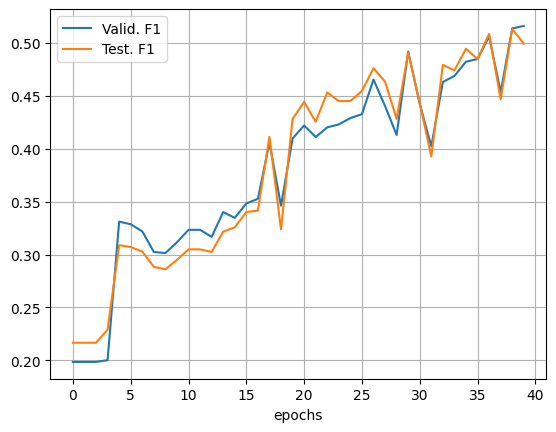

In [13]:
stats_df = pd.DataFrame(training_stats)[["Valid. F1", "Test. F1"]]
stats_df.plot(xlabel = "epochs", grid = True)

<Axes: xlabel='epochs'>

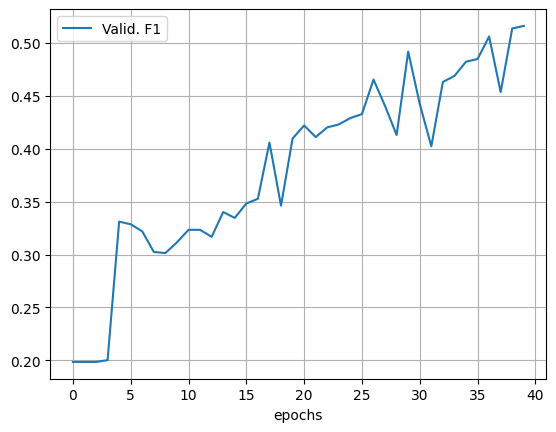

In [14]:
stats_df = pd.DataFrame(training_stats)[["Valid. F1"]]
stats_df.plot(xlabel = "epochs", grid = True)

<Axes: xlabel='epochs'>

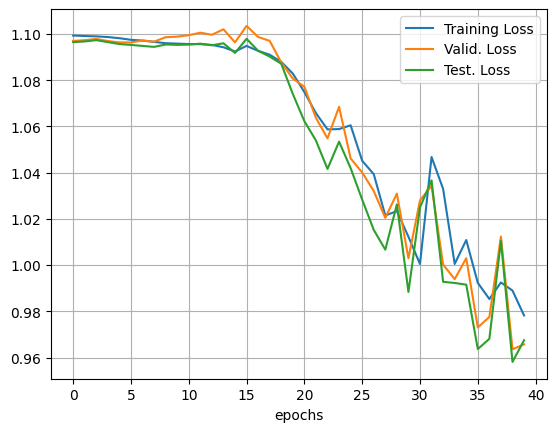

In [15]:
stats_df = pd.DataFrame(training_stats)[["Training Loss", "Valid. Loss", "Test. Loss"]]
stats_df.plot(xlabel = "epochs", grid = True)

<Axes: xlabel='epochs'>

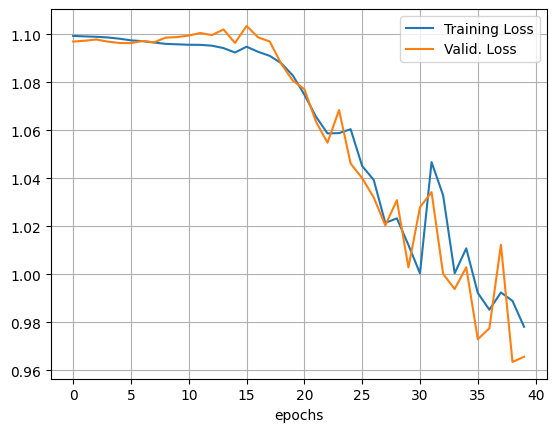

In [16]:
stats_df = pd.DataFrame(training_stats)[["Training Loss", "Valid. Loss"]]
stats_df.plot(xlabel = "epochs", grid = True)

## Modelling emotions in dialogues using CRF model
- https://www.geeksforgeeks.org/conditional-random-fields-crfs-for-pos-tagging-in-nlp/
- https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html#

In [ ]:
from sklearn_crfsuite import metrics

In [ ]:
df = pd.DataFrame(data_diag)
# train_df = df[(df["split"] == "train") | (df["split"] == "dev")]
train_df = df[df["split"] == "train"]
dev_df = df[df["split"] == "dev"]
test_df = df[df["split"] == "test"]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_path, do_lower_case=True)
bert = AutoModel.from_pretrained(model_path).to("cuda")

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def get_features(x):
    """
    for a dialogue
    """
    encoding = tokenizer.batch_encode_plus(
        x,
        add_special_tokens = True,
        max_length = 70, ###
        padding = 'max_length',
        truncation = 'longest_first',
        return_attention_mask = True,
        return_token_type_ids = False,
        return_tensors = 'pt'
    )
    with torch.no_grad():
        _, cls_embedding = bert(
            input_ids = encoding['input_ids'].to("cuda"),
            attention_mask = encoding['attention_mask'].to("cuda"),
            return_dict = False
        )
    # CRF takse in dictionary of features (need to convert embedding to required format)
    features = [{str(i):v.item() for i, v in enumerate(emb)} for emb in cls_embedding]
    return features

In [ ]:
# Extract features
label_mapper = {"negative": 0, "neutral": 1, "positive": 2}
X_train = []
y_train = []
for raw, y in zip(train_df["raw"], train_df["sentiment"]):
    X_train.append(get_features(raw))
    y_train.append(y)
X_test = []
y_test = []
for raw, y in zip(test_df["raw"], test_df["sentiment"]):
    X_test.append(get_features(raw))
    y_test.append(y)
X_dev = []
y_dev = []
for raw, y in zip(dev_df["raw"], dev_df["sentiment"]):
    X_dev.append(get_features(raw))
    y_dev.append(y)

In [ ]:
# hyperparameter tuning
parameters = {
    "c1": [0.1, 0.3, 0.5, 0.7],
    "c2": [0.1, 0.3, 0.5, 0.7]
}
perf = {}
for c1 in parameters["c1"]:
    for c2 in parameters["c2"]:
        print(f"Doing {c1}_{c2}...")
        crf = sklearn_crfsuite.CRF(
            algorithm='lbfgs',
            c1=c1,
            c2=c2,
            max_iterations=300,
            all_possible_transitions=True
        )

        try:
            crf.fit(X_train, y_train)
        except AttributeError:
            pass
        y_pred = crf.predict(X_dev)
        perf[f"{c1}_{c2}"] = metrics.flat_f1_score(y_dev, y_pred, average = "macro")
        print(perf[f"{c1}_{c2}"])
        print("-"*80)

Doing 0.1_0.1...
0.5516706611649885
--------------------------------------------------------------------------------
Doing 0.1_0.3...
0.5237732059666583
--------------------------------------------------------------------------------
Doing 0.1_0.5...
0.5069843437258097
--------------------------------------------------------------------------------
Doing 0.1_0.7...
0.5163186400078338
--------------------------------------------------------------------------------
Doing 0.3_0.1...
0.552577334809893
--------------------------------------------------------------------------------
Doing 0.3_0.3...
0.5066213449748954
--------------------------------------------------------------------------------
Doing 0.3_0.5...
0.5074286737727977
--------------------------------------------------------------------------------
Doing 0.3_0.7...
0.49604647233203575
--------------------------------------------------------------------------------
Doing 0.5_0.1...
0.5388468005186161
----------------------------

In [ ]:
# Train a CRF model on the training and dev data (best parameters)
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.3, ###
    c2=0.1, ###
    max_iterations=300,
    all_possible_transitions=True
)

try:
    crf.fit(X_train+X_dev, y_train+y_dev)
except AttributeError:
    pass

In [ ]:
# Make predictions on the test data and evaluate the performance
y_pred = crf.predict(X_test)
print(metrics.flat_f1_score(y_test, y_pred, average = "macro"))

preds = []
labels = []
for i in range(len(y_pred)):
    preds.extend(y_pred[i])
    labels.extend(y_test[i])
print(classification_report(
    labels, preds, digits=3
))

0.6078403849926896
              precision    recall  f1-score   support

    negative      0.642     0.478     0.548       833
     neutral      0.672     0.861     0.755      1256
    positive      0.617     0.451     0.521       521

    accuracy                          0.657      2610
   macro avg      0.644     0.597     0.608      2610
weighted avg      0.651     0.657     0.642      2610



In [ ]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(5))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-5:])

Top likely transitions:
negative -> negative 0.681834
positive -> positive 0.495551
neutral -> negative 0.115793
neutral -> neutral 0.099928
neutral -> positive 0.045502

Top unlikely transitions:
neutral -> positive 0.045502
positive -> negative -0.172487
positive -> neutral -0.182829
negative -> neutral -0.288441
negative -> positive -0.413957
